In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2026-02-01 20:05:32.054855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-01 20:05:32.872273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-01 20:05:34.558574: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


config

In [2]:
CSV_PATH = "../processing/master_with_paths.csv"

ALLOWED_LIGHT_FOLDERS = {"Point Light", "Spot Light", "Area Light"}
MATERIAL = "PlasticGlossy"
BATCH = "Batch 3 - Cycles Filmic"
NUM_ACTIVE_LIGHTS = 1

data preprocessing

In [3]:
# put csv data into dataframes
df = pd.read_csv(CSV_PATH, low_memory=False)
filtered = df[
    df["light_folder"].isin(ALLOWED_LIGHT_FOLDERS)
    & (df["num_active_lights"].astype(int) == NUM_ACTIVE_LIGHTS)
    & (df["material_folder"].astype(str) == MATERIAL)
    & (df["batch_folder"].astype(str) == BATCH)
].copy()

# relevant columns + per-light data + camera data
base_cols = [
    "image_relpath",
    "shape_name",
    "material_folder",
    "light_folder",
    "batch_folder",
    "frame",
    "config_id",
    "camera_png",
    "camera_name",
    "cam_pos_x", "cam_pos_y", "cam_pos_z",
    "cam_forward_x", "cam_forward_y", "cam_forward_z",
    "cam_up_x", "cam_up_y", "cam_up_z",
    "cam_right_x", "cam_right_y", "cam_right_z",
    "focal_length_mm",
    "hdri_path",
    "ambient_strength",
    "hdri_rot_z_rad",
]

# per-light columns
light_cols = [c for c in filtered.columns if c.startswith("light0_")]
keep_cols = [c for c in base_cols if c in filtered.columns] + light_cols
filtered = filtered[keep_cols].copy()

# clean up
numeric_prefixes = (
    "cam_", "light0_", "ambient_strength", "hdri_rot_z_rad", "focal_length_mm", "frame", "config_id", "camera_png"
)
for col in filtered.columns:
    if col.startswith(("cam_", "light0_")) or col in {"ambient_strength", "hdri_rot_z_rad", "focal_length_mm", "frame", "config_id", "camera_png"}:
        filtered[col] = pd.to_numeric(filtered[col], errors="coerce")

# split into df by lighting setup
dfs_by_setup = {
    setup: grp.reset_index(drop=True)
    for setup, grp in filtered.groupby("light_folder", sort=True)
}

In [5]:
def load_and_resize_image(image_path, size=(224, 224)):
    """Load an image and resize it to the specified size."""
    try:
        img = Image.open(image_path)
        img = img.resize(size, Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def process_images_for_df(df, dataset_root="../data"):
    """Process images in the dataframe to 224x224 and add them as an array column."""
    images = []
    valid_indices = []
    
    for idx, row in df.iterrows():
        img_path = os.path.join(dataset_root, row["image_relpath"])
        img_array = load_and_resize_image(img_path)
        
        if img_array is not None:
            images.append(img_array)
            valid_indices.append(idx)
        else:
            print(f"Skipping row {idx}: {img_path}")
    
    # filter to only include valid images
    df_processed = df.iloc[valid_indices].reset_index(drop=True)
    df_processed["image"] = images
    
    return df_processed

# process images for each lighting setup
images_by_setup = { setup: process_images_for_df(grp) for setup, grp in dfs_by_setup.items()}

In [6]:
# lighting features to predict
lighting_features = [
    "light0_energy",
    "light0_color_r", "light0_color_g", "light0_color_b",
    "light0_dir_cam_x", "light0_dir_cam_y", "light0_dir_cam_z",
]

# all processed dataframes
combined_df = pd.concat([df for df in images_by_setup.values()], ignore_index=True)

# extract images
X_images = np.array([img.astype(np.float32) / 255.0 for img in combined_df["image"]])
# extract targets 
y_targets = combined_df[lighting_features].astype(np.float32).values

# log-energy for stability
y_targets[:, 0] = np.log(y_targets[:, 0] + 1e-6)
# normalize direction gt to unit vectors
d = y_targets[:, -3:]
d = d / (np.linalg.norm(d, axis=1, keepdims=True) + 1e-8)
y_targets[:, -3:] = d

# normalize target features
scaler = StandardScaler()

# cnn model to predict lighting features from images
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(lighting_features), activation='linear') # output layer
])

# compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(model.summary())
print(f"\nTraining data shape: {X_images.shape}")
# lighting features to predict
lighting_features = [
    "light0_energy",
    "light0_color_r", "light0_color_g", "light0_color_b",
    "light0_dir_cam_x", "light0_dir_cam_y", "light0_dir_cam_z",
]

# all processed dataframes
combined_df = pd.concat([df for df in images_by_setup.values()], ignore_index=True)

# extract images
X_images = np.array([img.astype(np.float32) / 255.0 for img in combined_df["image"]])
# extract targets 
y_targets = combined_df[lighting_features].astype(np.float32).values

# log-energy for stability
y_targets[:, 0] = np.log(y_targets[:, 0] + 1e-6)
# normalize direction gt to unit vectors
d = y_targets[:, -3:]
d = d / (np.linalg.norm(d, axis=1, keepdims=True) + 1e-8)
y_targets[:, -3:] = d

# normalize target features
scaler = StandardScaler()

# cnn model to predict lighting features from images
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(lighting_features), activation='linear') # output layer
])

# compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(model.summary())
print(f"\nTraining data shape: {X_images.shape}")
print(f"Target data shape: {y_targets.shape}")

/home/kaclark219/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1769998086.514030    4183 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769998086.519242    4183 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,529,223 (169.87 MB)

 Trainable params: 44,529,223 (169.87 MB)

 Non-trainable params: 0 (0.00 B)

None

Training data shape: (7956, 224, 224, 3)


/home/kaclark219/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,529,223 (169.87 MB)

 Trainable params: 44,529,223 (169.87 MB)

 Non-trainable params: 0 (0.00 B)

None

Training data shape: (7956, 224, 224, 3)
Target data shape: (7956, 7)


Training samples: 6120
Test samples: 1836
Epoch 1/20


2026-02-01 20:16:38.511842: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 3684925440 exceeds 10% of free system memory.


192/192 ━━━━━━━━━━━━━━━━━━━━ 181s 934ms/step - loss: 0.1465 - mae: 0.2380 - val_loss: 0.0277 - val_mae: 0.0897
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 178s 929ms/step - loss: 0.0495 - mae: 0.1379 - val_loss: 0.0152 - val_mae: 0.0586
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 178s 929ms/step - loss: 0.0395 - mae: 0.1147 - val_loss: 0.0187 - val_mae: 0.0678
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 933ms/step - loss: 0.0299 - mae: 0.0971 - val_loss: 0.0059 - val_mae: 0.0401
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 932ms/step - loss: 0.0284 - mae: 0.0902 - val_loss: 0.0079 - val_mae: 0.0392
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 934ms/step - loss: 0.0258 - mae: 0.0840 - val_loss: 0.0064 - val_mae: 0.0365
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 933ms/step - loss: 0.0232 - mae: 0.0781 - val_loss: 0.0042 - val_mae: 0.0325
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 178s 928ms/step - loss: 0.0224 - mae: 0.0753 - val_loss: 0.0027 - val_mae: 0.0252
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━

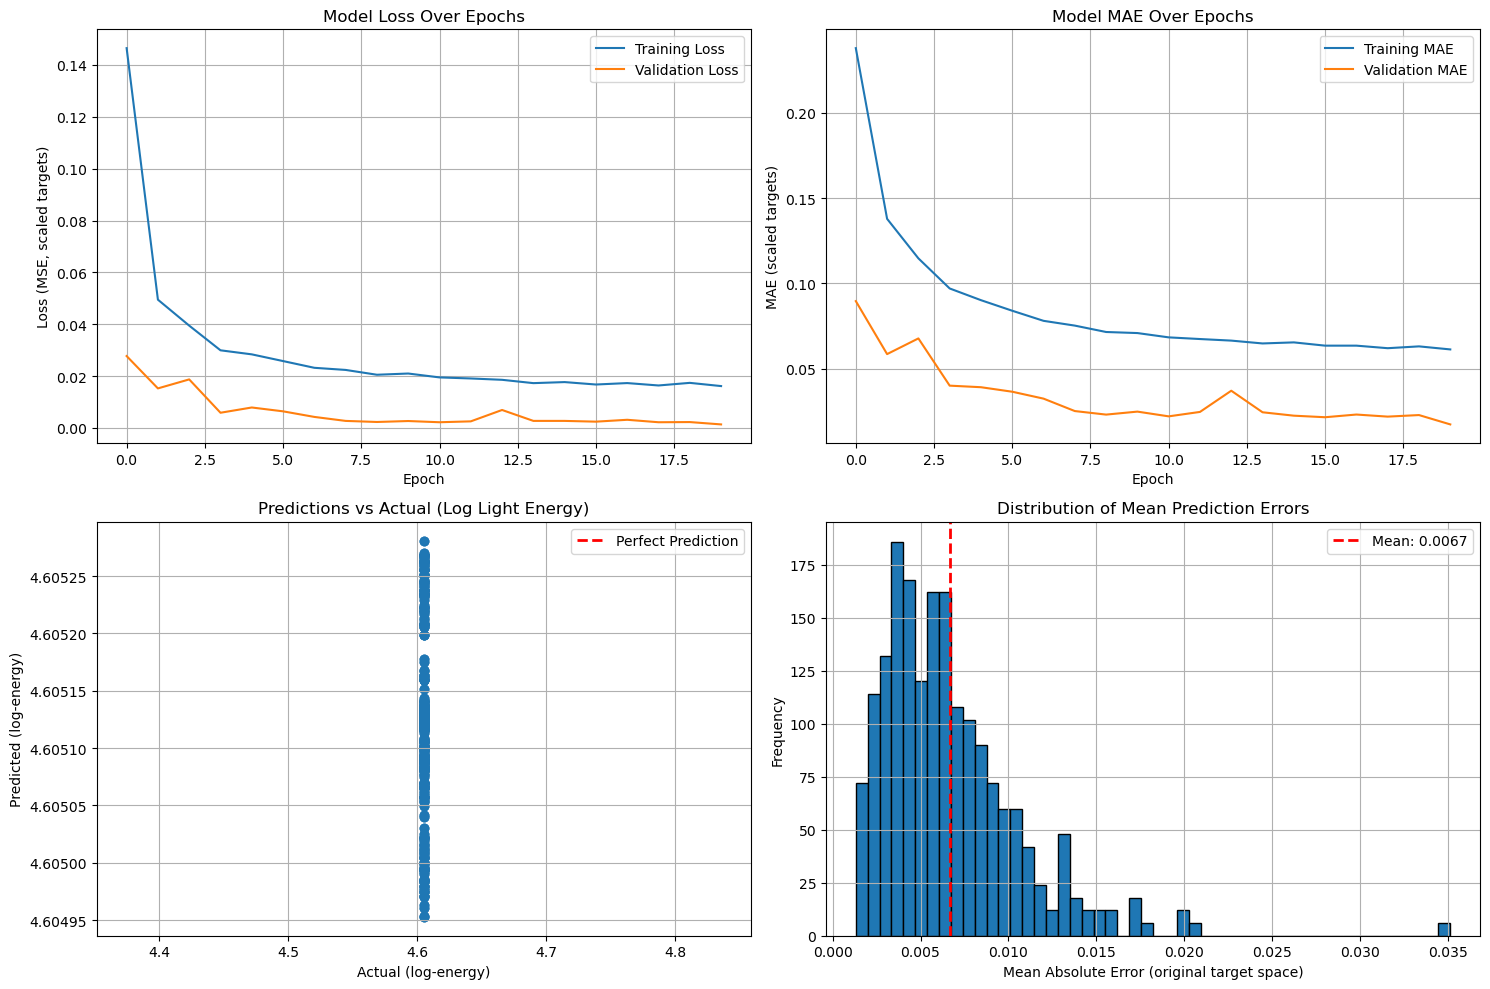


Per-feature MAE on test set (original target space):
light0_energy: 0.0001
light0_color_r: 0.0000
light0_color_g: 0.0002
light0_color_b: 0.0001
light0_dir_cam_x: 0.0137
light0_dir_cam_y: 0.0135
light0_dir_cam_z: 0.0189


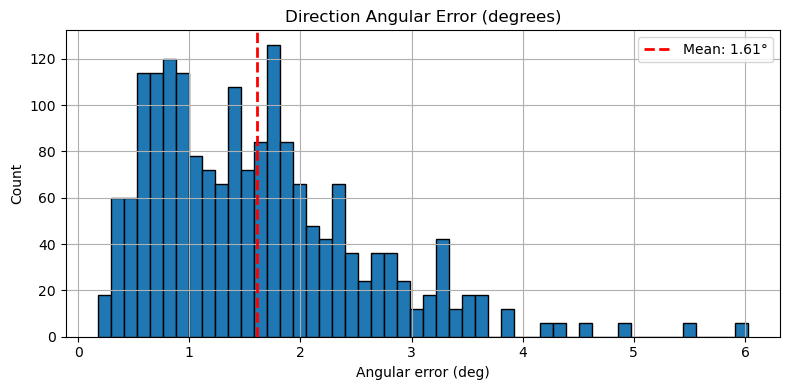

In [7]:
# split by config_id to avoid leakage
config_ids = combined_df["config_id"].values
unique_configs = np.unique(config_ids)

train_cfgs, test_cfgs = train_test_split(
    unique_configs, test_size=0.2, random_state=42
)

train_mask = np.isin(config_ids, train_cfgs)
test_mask  = np.isin(config_ids, test_cfgs)

X_train = X_images[train_mask]
X_test  = X_images[test_mask]

y_train = y_targets[train_mask]
y_test  = y_targets[test_mask]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# scale targets
scaler = StandardScaler()

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled  = scaler.transform(y_test)

# train the model
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    epochs=20,
    batch_size=32,
    verbose=1
)

# evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test_scaled, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# calculations for qualitative metrics
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = y_test

dir_true = y_true[:, -3:]
dir_pred = y_pred[:, -3:]

# re-normalize predicted dirs
dir_pred = dir_pred / (np.linalg.norm(dir_pred, axis=1, keepdims=True) + 1e-8)
dir_true = dir_true / (np.linalg.norm(dir_true, axis=1, keepdims=True) + 1e-8)

cos = np.sum(dir_true * dir_pred, axis=1)
cos = np.clip(cos, -1.0, 1.0)
ang_deg = np.degrees(np.arccos(cos))

print(f"Mean direction angular error: {ang_deg.mean():.2f}°")
print(f"Median direction angular error: {np.median(ang_deg):.2f}°")

# create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# training & validation loss
axes[0, 0].plot(history.history["loss"], label="Training Loss")
axes[0, 0].plot(history.history["val_loss"], label="Validation Loss")
axes[0, 0].set_title("Model Loss Over Epochs")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss (MSE, scaled targets)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# training & validation mae
axes[0, 1].plot(history.history["mae"], label="Training MAE")
axes[0, 1].plot(history.history["val_mae"], label="Validation MAE")
axes[0, 1].set_title("Model MAE Over Epochs")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("MAE (scaled targets)")
axes[0, 1].legend()
axes[0, 1].grid(True)

# predictions vs actual for light energy (log-energy space)
axes[1, 0].scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)
mn, mx = y_true[:, 0].min(), y_true[:, 0].max()
axes[1, 0].plot([mn, mx], [mn, mx], "r--", lw=2, label="Perfect Prediction")
axes[1, 0].set_title("Predictions vs Actual (Log Light Energy)")
axes[1, 0].set_xlabel("Actual (log-energy)")
axes[1, 0].set_ylabel("Predicted (log-energy)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# error distribution in original target space
errors = np.abs(y_true - y_pred)
mean_errors = errors.mean(axis=1)
axes[1, 1].hist(mean_errors, bins=50, edgecolor="black")
axes[1, 1].set_title("Distribution of Mean Prediction Errors")
axes[1, 1].set_xlabel("Mean Absolute Error (original target space)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].axvline(mean_errors.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_errors.mean():.4f}")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# per-feature MAE (original target space)
print("\nPer-feature MAE on test set (original target space):")
feature_errors = np.mean(np.abs(y_true - y_pred), axis=0)
for i, feature in enumerate(lighting_features):
    print(f"{feature}: {feature_errors[i]:.4f}")

# direction angular error histogram
plt.figure(figsize=(8, 4))
plt.hist(ang_deg, bins=50, edgecolor="black")
plt.title("Direction Angular Error (degrees)")
plt.xlabel("Angular error (deg)")
plt.ylabel("Count")
plt.axvline(ang_deg.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {ang_deg.mean():.2f}°")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()